In [24]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import xml.etree.ElementTree as ET

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
%matplotlib inline

In [25]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data)).convert("RGB")
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      None,
      category_index,
      use_normalized_coordinates=False,
      min_score_thresh=0.8)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

In [26]:
def get_images_n_annotations(path):
    names = os.listdir(path)
    img_names = [(os.path.join(path, name)) for name in names if not names.index(name)%2]
    ann_names = [(os.path.join(path, name)) for name in names if names.index(name)%2]
    images = []
    annotations = []
    for img_name, ann_name in zip(img_names, ann_names):
        img = load_image_into_numpy_array(img_name)
        images.append(img)
        ann_tree = ET.parse(ann_name)
        boxes = []
        labels = []
        lab_leg = {'apple': 1, 'banana':2, 'orange':3}
        root = ann_tree.getroot()
        for objects in root.findall("object"):
            labels.append(lab_leg[objects[0].text])
            for bndbox in objects.findall("bndbox"):
                listbnd = list(bndbox)
                boxes.append([int(listbnd[1].text), int(listbnd[0].text), int(listbnd[3].text), int(listbnd[2].text)])
        bndbox = np.array(boxes, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)
        target = {}
        target['boxes'] = bndbox
        target['labels'] = labels
        annotations.append(target)
    return images, annotations

In [27]:
folder_path = r"D:\Datasets\Apple obj-det\train"
train_images_np, annotations = get_images_n_annotations(folder_path)

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np[:4]):
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
plt.show()

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


C:\Python\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


KeyboardInterrupt: 

In [ ]:
gt_boxes = [an["boxes"] for an in annotations]
num_classes = 3
category_index = {1: {'id': 1, 'name': 'apple'}, 2: {'id': 2, 'name': 'banana'}, 3: {'id': 3, 'name': 'orange'}}
labels = [an["labels"] for an in annotations]
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np, label) in zip(train_images_np, gt_boxes, labels):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

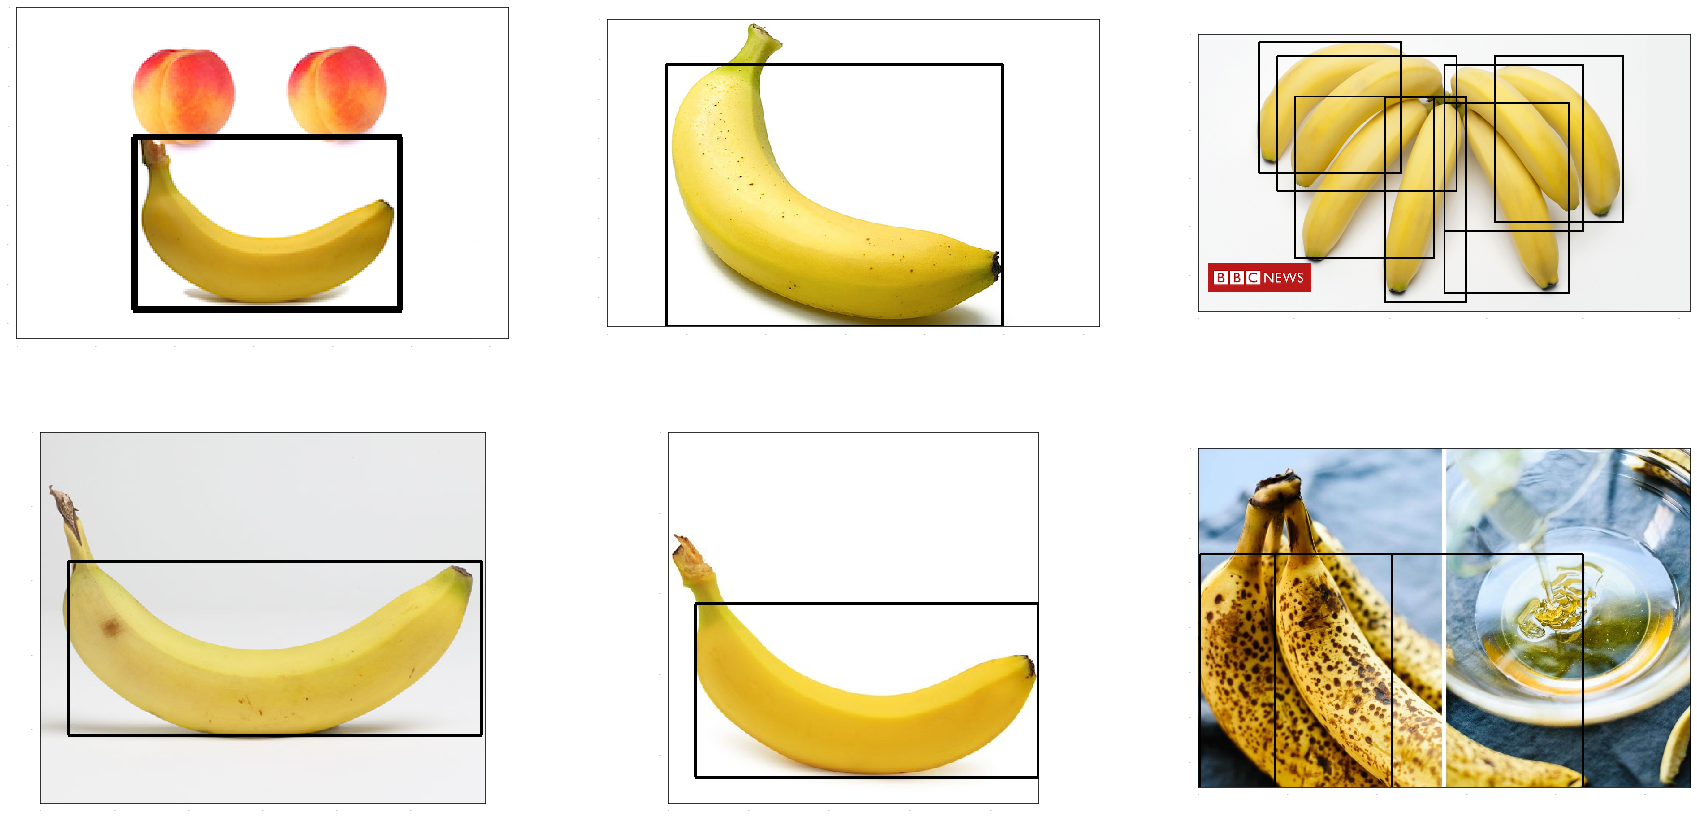

In [18]:
plt.figure(figsize=(30, 15))
i = 0
for idx in range(100, 106):
    i+=1
    dummy_scores = np.array([1.0, 0.0, 0.0], dtype=np.float32)
    plt.subplot(2, 3, i)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, 
        category_index)
plt.show()